In [3]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, balanced_accuracy_score, confusion_matrix
import pymongo
import pandas as pd
from collections import Counter
from collections import OrderedDict

mongohost = "192.168.0.246"
mongoport = 15213
collection = 'MLresults_wideGamma'

# instantiate the mongo client
client = pymongo.MongoClient(mongohost, mongoport)
# get handle to database
db = client.ferret
plt.rcParams['svg.fonttype'] = 'none'


In [19]:
def getClassifierAccuracies(sub, classifierName, hmapBool=0,location = [], mode = 1):
    
    sort_dict = {}
    if classifierName == 'Linear SVM':
        sort_dict['hyper_consistency'] = -1
    else:        
        sort_dict['neighbor_consistency'] = -1
        
    if mode == 1:
        numDocs = 10000
    else:
        numDocs = 10
        
    if location:
        matchDict = {"subject":sub,
                    "classifier": classifierName,
                    "feats":{"$nin":[7,8,'pca','all']},
                    "locs": location,}
    else:
        matchDict = {"subject":sub,
                    "classifier": classifierName,
                    "feats":{"$nin":[7,8,'pca','all']}}
            
    result = db.command({
            'aggregate': collection,
            'pipeline': [
                {'$match': matchDict},
                {"$project": {
                    "_id": 0,
                    "label": ["$subject","$states","$locs","$feats","$numObservations",],
                    "numFeats": {"$size": "$feats"},
                    "accuracy": {"$avg":"$accuracyList"},
                    "std": {"$stdDevSamp": "$accuracyList"},
                    'hyper_consistency':'$combined_consistency',
                    'hyper_optimal':'$combined_params',
                    'neighbor_consistency':'$neighbor_consistency',
                    'optimal_params':'$optimal_params'
                }},
                {"$sort": sort_dict},
                {'$limit':numDocs},
                {"$sort": {'accuracy':-1}},
            ]})
    return result['result']

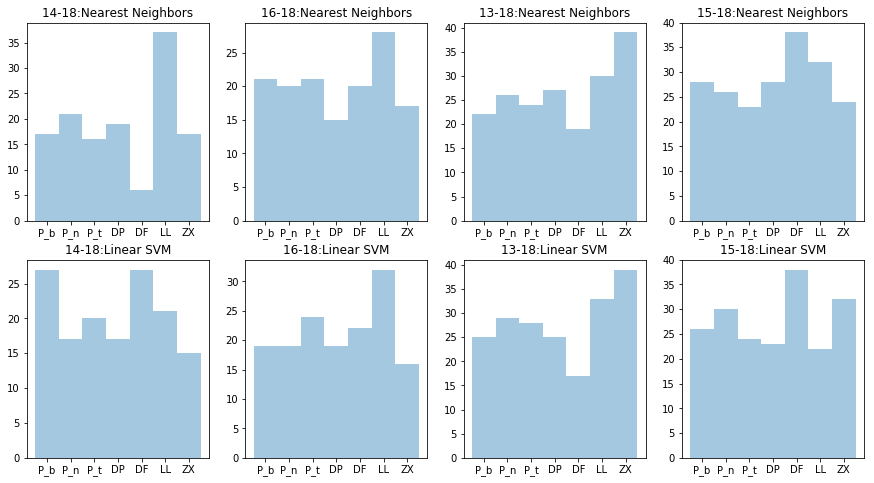

In [20]:
# names = ["Nearest Neighbors", "Linear SVM","Naive Bayes"]
# paddleOrder = ['S1','S2','S3','S4']\
# 1/2/3/4/5/6/7/8/9  => bradyPercent/normoPercent/tachyPercent/DP/DF/LL/A/E/ZX

f,ax = plt.subplots(2,4,figsize=(15,8))
for iSub, subj in enumerate(['14-18','16-18','13-18','15-18']):
    for idx, classifier  in  enumerate(["Nearest Neighbors", "Linear SVM"]):
        allObj = getClassifierAccuracies(subj,classifier)
        percentile90 = int(len(allObj)*0.1)
        
#         print percentile90
        featList = []
        for iObj in allObj[:percentile90]:
#             if iObj['accuracy'] > 0.8:
            featList.extend(iObj['label'][3])
        
        featListMod = [7 if x==9 else x for x in featList]

        sns.distplot(featListMod,bins =  [0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5], ax=ax[idx][iSub],kde=False)
        ax[idx][iSub].set_xticks([1,2,3,4,5,6,7])
        ax[idx][iSub].set(xticklabels=['P_b','P_n','P_t','DP','DF','LL','ZX'])
        ax[idx][iSub].title.set_text("%s:%s" %(subj,classifier))
        
f.savefig('optimal_feats.svg')

[u'S2', u'S3', u'S4']
[u'S1', u'S3', u'S4']
[u'S1', u'S2', u'S3', u'S4']
[u'S1S1', u'S3S1', u'S4S1', u'S4S3']


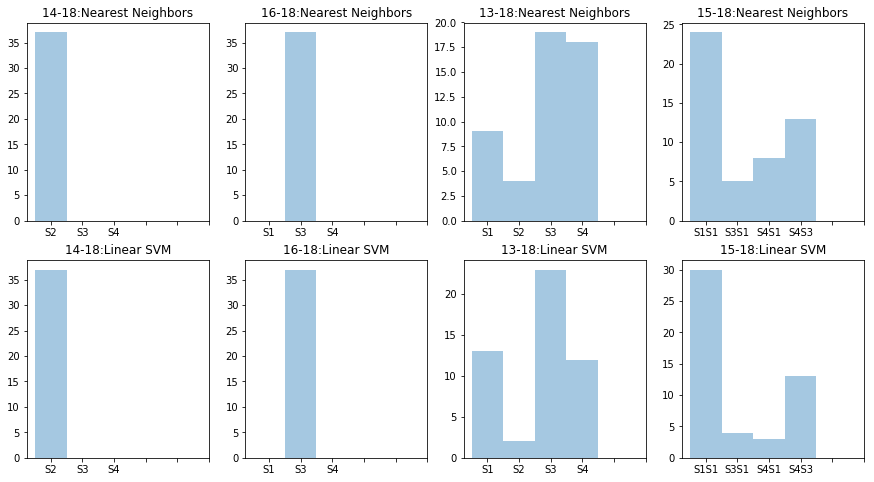

In [21]:
f,ax = plt.subplots(2,4,figsize=(15,8))
for iSub, subj in enumerate(['14-18','16-18','13-18','15-18']):
    paddleOrder = sorted(db[collection].find({'subject':subj}).distinct('locs'))
    print paddleOrder
    for idx, classifier  in  enumerate(["Nearest Neighbors", "Linear SVM"]):
        allObj = getClassifierAccuracies(subj,classifier)
        percentile90 = int(len(allObj)*0.1)
        
        locationList = []
        for iObj in allObj[:percentile90]:
#             if isinstance(iObj['label'],list):
#                 locationList.extend(iObj['label'][2])
#             else:
            locationList.append(iObj['label'][2])
                    
        
#         print locationList
        locationIdx = [paddleOrder.index(i) for i in locationList]
#         print locationList 
        sns.distplot(locationIdx, bins = [-0.5, 0.5, 1.5,2.5,3.5,4.5], ax=ax[idx][iSub],kde=False)
        ax[idx][iSub].title.set_text("%s:%s" %(subj,classifier))
        ax[idx][iSub].set_xticks([0,1,2,3,4,5])
        ax[idx][iSub].set(xticklabels=paddleOrder)

f.savefig('optimal_segments.svg')

# optimal hyperparameters

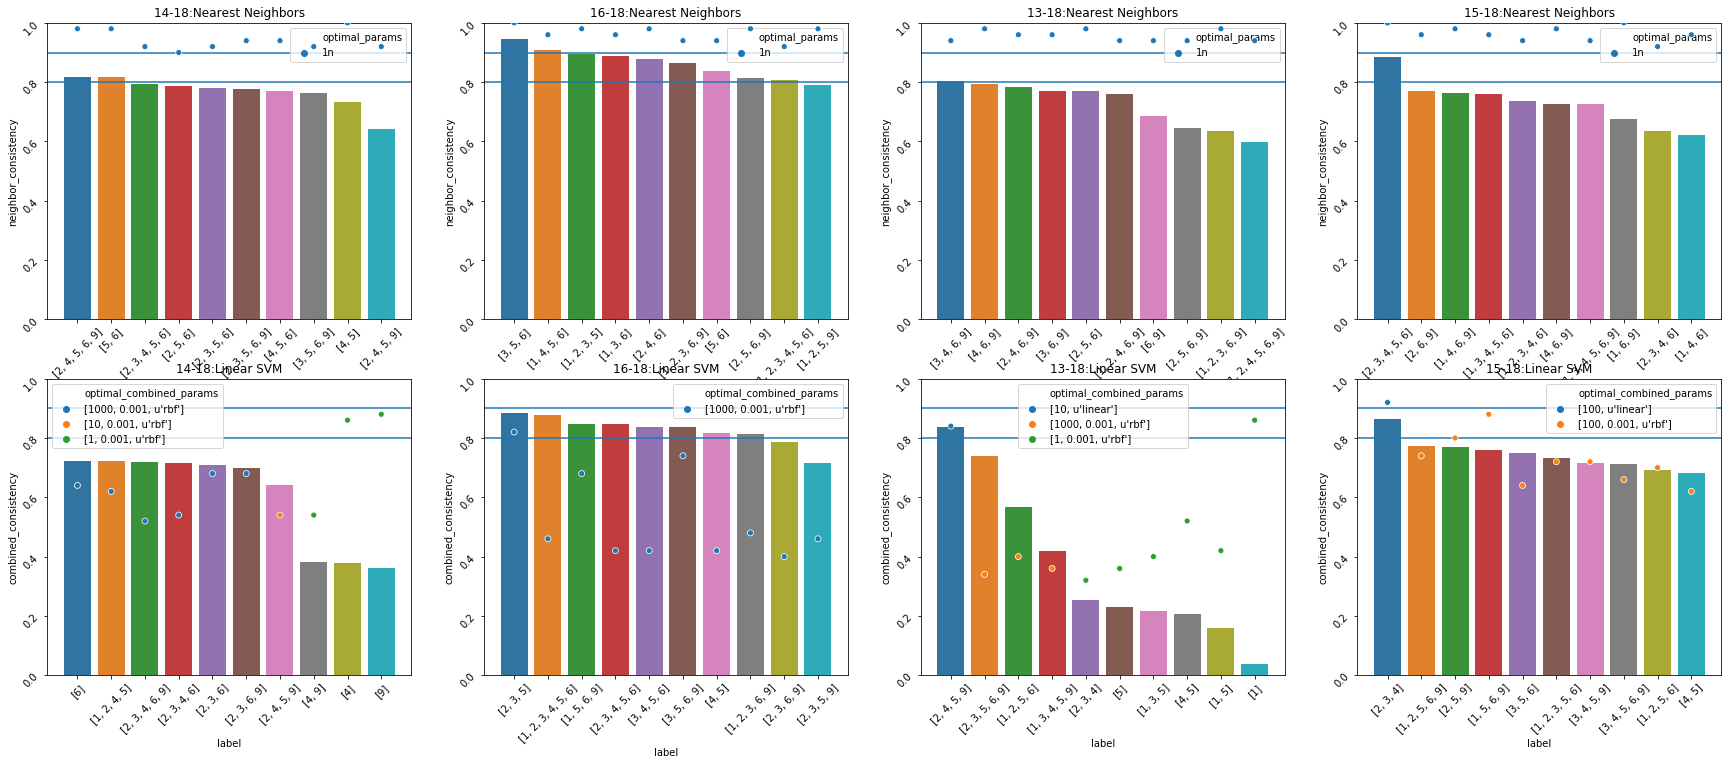

In [22]:
# names = ["Nearest Neighbors", "Linear SVM","Naive Bayes"]
# paddleOrder = ['S1','S2','S3','S4']\
# 1/2/3/4/5/6/7/8/9  => bradyPercent/normoPercent/tachyPercent/DP/DF/LL/A/E/ZX
location =['S2','S3','S3','S1S1']
classifier = "Nearest Neighbors"
f,ax = plt.subplots(2,4,figsize=(30,12))
for iSub, subj in enumerate(['14-18','16-18','13-18','15-18']): # 
    allObj = getClassifierAccuracies(subj,classifier,location = location[iSub], mode = 2)
    percentile90 = 13 #int(len(allObj)*0.1)

    performanceList = []
    for iObj in allObj[:percentile90]:
#         new_vals = Counter(iObj['neighbors']).most_common()
#         optimal_neighbors = '%sn' %new_vals[::1][0][0]
        performanceList.append({'neighbor_consistency':iObj['neighbor_consistency'],
                                'optimal_params':iObj['optimal_params'],
                                'accuracy':iObj['accuracy'],
                                'label':str(iObj['label'][3])})
    if performanceList:
        df = pd.DataFrame(performanceList)
        sns.barplot(x='label', y='accuracy', data = df, ax=ax[0][iSub])
        scatterPts = sns.scatterplot(x='label', y='neighbor_consistency', data=df, ax=ax[0][iSub],hue='optimal_params',zorder=100)
        ax[0][iSub].title.set_text("%s:%s" %(subj,classifier))
        ax[0][iSub].set_ylim(0,1)
        ax[0][iSub].tick_params(labelrotation=45)
        ax[0][iSub].axhline(y=0.8, xmin=0, xmax=1)
        ax[0][iSub].axhline(y=0.9, xmin=0, xmax=1)
    
    
    
    
classifier = "Linear SVM"
for iSub, subj in enumerate(['14-18','16-18','13-18','15-18']): # 
    allObj = getClassifierAccuracies(subj,classifier,location = location[iSub], mode = 2)
    percentile90 = 13# int(len(allObj)*0.1)

#         print percentile90
#     featList = []
#     accuracyList = []
#     C_consistency = []
#     gamma_consistency = []
#     kernel_consistency = []
    performanceList = []
    for iObj in allObj[:percentile90]:
#         new_vals1 = Counter(iObj['C']).most_common()
#         C_consistency = new_vals1[::1][0][1]/50.0
        
#         new_vals3 = Counter(iObj['kernel']).most_common()
#         kernel_consistency = new_vals3[::1][0][1]/50.0

#         if 'gamma' in iObj.keys():
#             new_vals2 = Counter(iObj['gamma']).most_common()
#             gamma_consistency = new_vals2[::1][0][1]/50.0
            
#             new_vals4 = Counter(zip(iObj['C'], iObj['gamma'], iObj['kernel'])).most_common()
#             combined_consistency = new_vals4[::1][0][1]/50.0
            
#             optimal_combined_params = Counter(zip(iObj['C'], iObj['gamma'], iObj['kernel'])).most_common()[::1][0][0]
            
#         else:
#             gamma_consistency = 99
#             combined_consistency = 99
#             optimal_combined_params = Counter(zip(iObj['C'], iObj['kernel'])).most_common()[::1][0][0]

        
#         optimalParams = '%d_%f_%s' %(new_vals1[::1][0][0], new_vals2[::1][0][0], new_vals3[::1][0][0])
                
        performanceList.append({#'C':C_consistency,
                                #'gamma':gamma_consistency,
                                #'kernel':kernel_consistency,
                                'accuracy':iObj['accuracy'],
#                                 'mean_consistency' : iObj['mean_consistency'],
                                'combined_consistency': iObj['hyper_consistency'],
                                'optimal_combined_params': str(iObj['hyper_optimal']),
                                'label':str(iObj['label'][3])})
    if performanceList:
        df = pd.DataFrame(performanceList)
        sns.barplot(x='label', y='accuracy', data=df, ax=ax[1][iSub])
    #     scatterPts = sns.scatterplot(x='label', y='C', data=df,  ax=ax[iSub],color='b',zorder=100)
    #     scatterPts = sns.scatterplot(x='label', y='gamma', data=df,  ax=ax[iSub],color='r',zorder=100)
    #     scatterPts = sns.scatterplot(x='label', y='kernel', data=df, ax=ax[iSub],color='g',zorder=100)
        scatterPts = sns.scatterplot(x='label', y='combined_consistency', data=df, ax=ax[1][iSub],hue='optimal_combined_params',zorder=100)
    #     ax[idx][iSub].setp(scatterPts.lines, zorder=100)
        ax[1][iSub].title.set_text("%s:%s" %(subj,classifier))
        ax[1][iSub].tick_params(labelrotation=45)
        ax[1][iSub].set_ylim(0,1)
        ax[1][iSub].axhline(y=0.8, xmin=0, xmax=1)
        ax[1][iSub].axhline(y=0.9, xmin=0, xmax=1)
        
f.savefig('optimal_classifier.svg')